## VGG, Data: EMNIST

**READ ME**

 Before running the code, make sure that data folder and code are in the same directory, and the data folder needs to contain four decompressed input files, which are named as ‘emnist-byclass-test-images-idx3-ubyte’, ‘emnist-byclass-test-labels-idx1-ubyte’, ‘emnist-byclass-train-images-idx3-ubyte’, ‘emnist-byclass-train-labels-idx1-ubyte’.
The code cells in the Setup and Preprocessing parts need to be run one by one. If you want to explore the whole building model step completely, you can run all the code cells in Build and tunning model one by one. If you only want to get the final tunned model, then you can run the summary module directly. Then run the complete prediction to predict on the test set.


## Setup

In [2]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import sys
import pandas as pd
import sklearn
import time
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Data direction
train_data_dir='./data/emnist-byclass-train-images-idx3-ubyte'
train_label_dir = './data/emnist-byclass-train-labels-idx1-ubyte'
test_data_dir = './data/emnist-byclass-test-images-idx3-ubyte'
test_label_dir = './data/emnist-byclass-test-labels-idx1-ubyte'

def decode_idx3_ubyte(file):
    '''
    file: file dirction
    return: data set
    '''

    # read binary data
    bin_read_data = open(file,'rb').read()

    offset = 0
    header = '>iiii'
    magic_num, num_img, num_row, num_col = struct.unpack_from(header, bin_read_data,offset)
    print('magic number: %d, number of images: %d, image size: %d*%d' % (magic_num, num_img, num_row, num_col ))

    img_size = num_row * num_col
    offset += struct.calcsize(header)
    print(offset)
    fmt_image = '>' + str(img_size) + 'B'
    print(fmt_image, offset, struct.calcsize(fmt_image))
    images = np.empty((num_img, num_row, num_col))

    for i in range(num_img):
        if (i +1) % 10000 == 0:
            print('Decode: %d' % (i+1))
            print(offset)
        images[i] = np.array(struct.unpack_from(fmt_image, bin_read_data, offset)).reshape((num_row, num_col))
        offset += struct.calcsize(fmt_image)
    return images

def decode_idx1_ubyte(file):
    bin_read_data = open(file, 'rb').read()
    offset = 0
    header = '>ii'
    magic_num, num_img = struct.unpack_from(header, bin_read_data,offset)
    print('magic number: %d, number of images: %d' % (magic_num, num_img))

    offset += struct.calcsize(header)
    fmt_img ='>B'
    labels = np.empty(num_img)
    for i in range(num_img):
        if (i + 1) % 10000 ==0:
            print('Decode: %d' %(i+1))
        labels[i] = struct.unpack_from(fmt_img,bin_read_data,offset)[0]
        offset += struct.calcsize(fmt_img)
    return labels

### Data loading

In [3]:
trian_img_raw = decode_idx3_ubyte(train_data_dir)
test_img_raw = decode_idx3_ubyte(test_data_dir)

magic number: 2051, number of images: 697932, image size: 28*28
16
>784B 16 784
Decode: 10000
7839232
Decode: 20000
15679232
Decode: 30000
23519232
Decode: 40000
31359232
Decode: 50000
39199232
Decode: 60000
47039232
Decode: 70000
54879232
Decode: 80000
62719232
Decode: 90000
70559232
Decode: 100000
78399232
Decode: 110000
86239232
Decode: 120000
94079232
Decode: 130000
101919232
Decode: 140000
109759232
Decode: 150000
117599232
Decode: 160000
125439232
Decode: 170000
133279232
Decode: 180000
141119232
Decode: 190000
148959232
Decode: 200000
156799232
Decode: 210000
164639232
Decode: 220000
172479232
Decode: 230000
180319232
Decode: 240000
188159232
Decode: 250000
195999232
Decode: 260000
203839232
Decode: 270000
211679232
Decode: 280000
219519232
Decode: 290000
227359232
Decode: 300000
235199232
Decode: 310000
243039232
Decode: 320000
250879232
Decode: 330000
258719232
Decode: 340000
266559232
Decode: 350000
274399232
Decode: 360000
282239232
Decode: 370000
290079232
Decode: 380000
29

In [4]:
train_lab_raw = decode_idx1_ubyte(train_label_dir)
test_lab_raw = decode_idx1_ubyte(test_label_dir)

magic number: 2049, number of images: 697932
Decode: 10000
Decode: 20000
Decode: 30000
Decode: 40000
Decode: 50000
Decode: 60000
Decode: 70000
Decode: 80000
Decode: 90000
Decode: 100000
Decode: 110000
Decode: 120000
Decode: 130000
Decode: 140000
Decode: 150000
Decode: 160000
Decode: 170000
Decode: 180000
Decode: 190000
Decode: 200000
Decode: 210000
Decode: 220000
Decode: 230000
Decode: 240000
Decode: 250000
Decode: 260000
Decode: 270000
Decode: 280000
Decode: 290000
Decode: 300000
Decode: 310000
Decode: 320000
Decode: 330000
Decode: 340000
Decode: 350000
Decode: 360000
Decode: 370000
Decode: 380000
Decode: 390000
Decode: 400000
Decode: 410000
Decode: 420000
Decode: 430000
Decode: 440000
Decode: 450000
Decode: 460000
Decode: 470000
Decode: 480000
Decode: 490000
Decode: 500000
Decode: 510000
Decode: 520000
Decode: 530000
Decode: 540000
Decode: 550000
Decode: 560000
Decode: 570000
Decode: 580000
Decode: 590000
Decode: 600000
Decode: 610000
Decode: 620000
Decode: 630000
Decode: 640000
Deco

## Preprocess data

### Scale data

In [5]:
X_train_full = trian_img_raw / 255.
X_test = test_img_raw / 255.

### View all labels

In [6]:
print(np.unique(train_lab_raw))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61.]


### Split training set into training set and validation set

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, train_lab_raw, train_size=0.9)

print(f"Shape of X_train: {X_train.shape}")

Shape of X_train: (628138, 28, 28)


In [8]:
X_train = np.expand_dims(X_train, -1)
X_valid = np.expand_dims(X_valid, -1)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_valid: {X_valid.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_valid: {y_valid.shape}")

Shape of X_train: (628138, 28, 28, 1)
Shape of X_valid: (69794, 28, 28, 1)
Shape of y_train: (628138,)
Shape of y_valid: (69794,)


## VGG model using Keras

In [9]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D , Flatten, Dropout, ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

### Tuning model layers and neurons

### VGG - two layers - neurons: 16,32

In [52]:
model_1 = Sequential()

# layer_1
model_1.add(Conv2D(16, (3, 3), strides=(1, 1), input_shape=(28, 28, 1)))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# layer_2
model_1.add(Conv2D(32, (3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

#full connected layer
model_1.add(Flatten())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(62, activation='softmax'))

model_1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               205056    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)              

In [53]:
model_1.compile(loss='sparse_categorical_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [55]:
batch_size = 128
epochs = 5
history_1 = model_1.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/5
4908/4908 [==============================] - 52s 10ms/step - loss: 1.4904 - accuracy: 0.6029 - val_loss: 0.7288 - val_accuracy: 0.7718
Epoch 2/5
4908/4908 [==============================] - 51s 10ms/step - loss: 0.8283 - accuracy: 0.7467 - val_loss: 0.5873 - val_accuracy: 0.8061
Epoch 3/5
4908/4908 [==============================] - 52s 11ms/step - loss: 0.7027 - accuracy: 0.7775 - val_loss: 0.5329 - val_accuracy: 0.8195
Epoch 4/5
4908/4908 [==============================] - 57s 12ms/step - loss: 0.6441 - accuracy: 0.7924 - val_loss: 0.5042 - val_accuracy: 0.8275
Epoch 5/5
4908/4908 [==============================] - 61s 12ms/step - loss: 0.6086 - accuracy: 0.8016 - val_loss: 0.4851 - val_accuracy: 0.8319


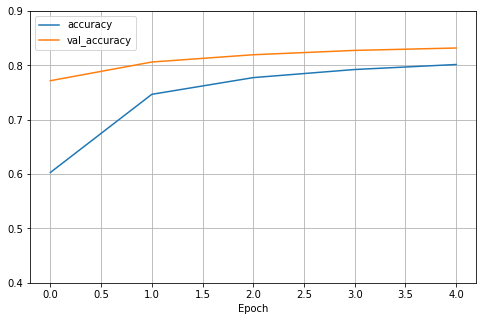

In [56]:
import pandas as pd
accuracies_1 = pd.DataFrame(history_1.history)[['accuracy','val_accuracy']]

accuracies_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.4,0.9)
plt.xlabel('Epoch')
plt.show()

In [57]:
print("VGG with two layers 32 and 64")
print(accuracies_1)

VGG with two layers 32 and 64
   accuracy  val_accuracy
0  0.602931      0.771757
1  0.746731      0.806144
2  0.777465      0.819540
3  0.792380      0.827507
4  0.801566      0.831934


### VGG - two layers - neurons: 32,64

In [20]:
model_2 = Sequential()

# layer_1
model_2.add(Conv2D(32, (3, 3), strides=(1, 1), input_shape=(28, 28, 1)))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# layer_2
model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

#full connected layer
model_2.add(Flatten())
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(62, activation='softmax'))

model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               409856    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [21]:
model_2.compile(loss='sparse_categorical_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [23]:
batch_size = 128
epochs = 5
history_2 = model_2.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/5
4908/4908 [==============================] - 115s 23ms/step - loss: 1.4574 - accuracy: 0.6119 - val_loss: 0.7130 - val_accuracy: 0.7777
Epoch 2/5
4908/4908 [==============================] - 131s 27ms/step - loss: 0.7881 - accuracy: 0.7572 - val_loss: 0.5649 - val_accuracy: 0.8120
Epoch 3/5
4908/4908 [==============================] - 132s 27ms/step - loss: 0.6688 - accuracy: 0.7863 - val_loss: 0.5141 - val_accuracy: 0.8248
Epoch 4/5
4908/4908 [==============================] - 137s 28ms/step - loss: 0.6135 - accuracy: 0.8001 - val_loss: 0.4877 - val_accuracy: 0.8311
Epoch 5/5
4908/4908 [==============================] - 126s 26ms/step - loss: 0.5802 - accuracy: 0.8088 - val_loss: 0.4709 - val_accuracy: 0.8356


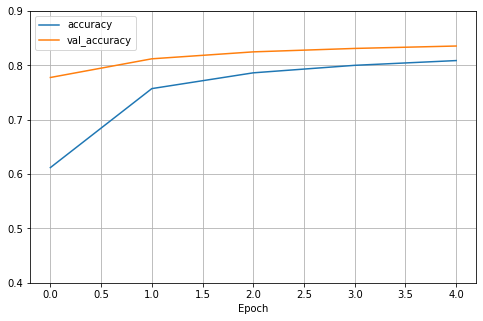

In [39]:
accuracies_2 = pd.DataFrame(history_2.history)[['accuracy','val_accuracy']]

accuracies_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.4,0.9)
plt.xlabel('Epoch')
plt.show()

In [43]:
print("VGG with two layers 32 and 64")
print(accuracies_2)

VGG with two layers 32 and 64
   accuracy  val_accuracy
0  0.611910      0.777689
1  0.757243      0.812047
2  0.786264      0.824827
3  0.800066      0.831146
4  0.808808      0.835573


### VGG - two layers - neurons: 64,128

In [47]:
model_3 = Sequential()

# layer_1
model_3.add(Conv2D(64, (3, 3), strides=(1, 1), input_shape=(28, 28, 1)))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# layer_2
model_3.add(Conv2D(128, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

#full connected layer
model_3.add(Flatten())
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(62, activation='softmax'))

model_3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               819456    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)              

In [48]:
model_3.compile(loss='sparse_categorical_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [18]:
batch_size = 128
epochs = 5
history_3 = model_3.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/5
4908/4908 [==============================] - 373s 76ms/step - loss: 1.4250 - accuracy: 0.6176 - val_loss: 0.6951 - val_accuracy: 0.7818
Epoch 2/5
4908/4908 [==============================] - 372s 76ms/step - loss: 0.7642 - accuracy: 0.7632 - val_loss: 0.5541 - val_accuracy: 0.8146cur - ETA: 42s - loss: 0.7734 - accuracy: 0.76 - ET - ETA: 39s - loss: 0.7727 - ETA: 38s - l - ETA: 36s - loss: 0.772 - ETA: 34 - ETA: 32s - loss: 0.7 - ETA: 30 - ETA: 27s - loss: 0.7701 - accuracy: 0.76 - ETA: 27s - loss: 0.7700 - accurac - ETA: 27s - loss: 0.7699 - accuracy: 0. - ETA: 26s - loss: 0.7698 - acc - ETA: 25s -  - ETA: 23s - los - ETA: 21s - loss: 0.7686 - accuracy: 0 - ETA: 21s - loss: 0.7685 - accuracy: 0.7 - ETA: 20s - ETA: 15s - loss: 0.7673 - accuracy: 0.76 - ETA: 15s - loss: 0. - ETA: 8s - loss: 0.7659 - accuracy: 0. - ETA: 8s - loss: 0.7659 - accura - ETA: 7s - loss: 0.7659 - accuracy:  - ETA: 7s - loss: 0.7 - E - ETA: 5s - loss: - ETA: 4s - loss: 0.7651 -  - ETA: 3s - ETA - ETA: 

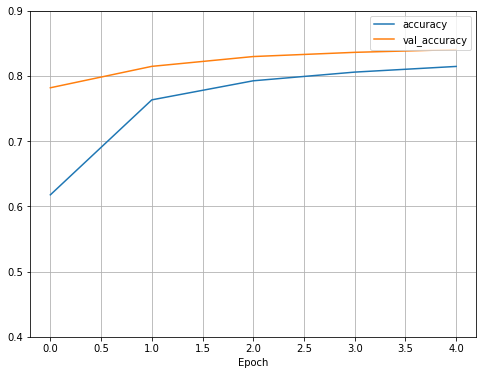

In [38]:
accuracies_3 = pd.DataFrame(history_3.history)[['accuracy','val_accuracy']]

accuracies_3.plot(figsize=(8,6))
plt.grid(True)
plt.gca().set_ylim(0.4,0.9)
plt.xlabel('Epoch')
plt.show()

In [44]:
print("VGG with two layers 64 and 128")
print(accuracies_3)

VGG with two layers 64 and 128
   accuracy  val_accuracy
0  0.617627      0.781772
1  0.763234      0.814583
2  0.792463      0.829627
3  0.805777      0.836075
4  0.814469      0.840258


### Compare: neurons of two layers

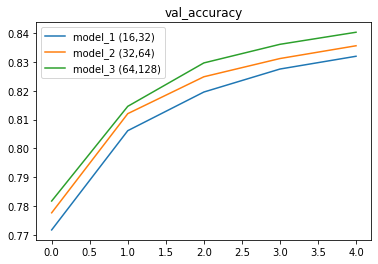

In [81]:
plt.plot(history_1.history['val_accuracy'],label = "model_1 (16,32)")
plt.plot(history_2.history['val_accuracy'],label = "model_2 (32,64)")
plt.plot(history_3.history['val_accuracy'],label = "model_3 (64,128)")
plt.title("val_accuracy")
plt.legend()
plt.show()


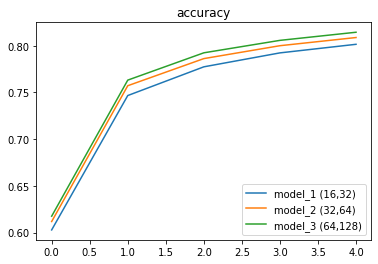

In [80]:
plt.plot(history_1.history['accuracy'],label = "model_1 (16,32)")
plt.plot(history_2.history['accuracy'],label = "model_2 (32,64)")
plt.plot(history_3.history['accuracy'],label = "model_3 (64,128)")
plt.title("accuracy")
plt.legend()
plt.show()


### The best number of neurons in two layers model is 64,128.   

### VGG - three layers - neurons: 64,128,256

In [9]:
model_4 = Sequential()

# layer_1
model_4.add(Conv2D(64, (3, 3), strides=(1, 1), input_shape=(28, 28, 1)))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

# layer_2
model_4.add(Conv2D(128, (3, 3), activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

# layer_3
model_4.add(Conv2D(256, (3, 3), activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

#full connected layer
model_4.add(Flatten())
model_4.add(Dense(256, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(62, activation='softmax'))

model_4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

In [10]:
model_4.compile(loss='sparse_categorical_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [11]:
batch_size = 128
epochs = 5
history_4 = model_4.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/5
4908/4908 [==============================] - 438s 89ms/step - loss: 1.8002 - accuracy: 0.5288 - val_loss: 0.8816 - val_accuracy: 0.7258
Epoch 2/5
4908/4908 [==============================] - 425s 87ms/step - loss: 0.9090 - accuracy: 0.7195 - val_loss: 0.6899 - val_accuracy: 0.7734
Epoch 3/5
4908/4908 [==============================] - 419s 85ms/step - loss: 0.7572 - accuracy: 0.7572 - val_loss: 0.6093 - val_accuracy: 0.7971
Epoch 4/5
4908/4908 [==============================] - 414s 84ms/step - loss: 0.6866 - accuracy: 0.7762 - val_loss: 0.5663 - val_accuracy: 0.8100
Epoch 5/5
4908/4908 [==============================] - 417s 85ms/step - loss: 0.6445 - accuracy: 0.7877 - val_loss: 0.5438 - val_accuracy: 0.8153


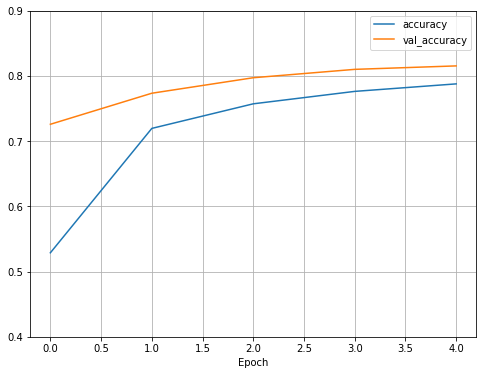

In [12]:
accuracies_4 = pd.DataFrame(history_4.history)[['accuracy','val_accuracy']]

accuracies_4.plot(figsize=(8,6))
plt.grid(True)
plt.gca().set_ylim(0.4,0.9)
plt.xlabel('Epoch')
plt.show()

In [20]:
print("VGG with three layers 64,128,256")
print(accuracies_4)

VGG with three layers 64,128,256
   accuracy  val_accuracy
0  0.528777      0.725793
1  0.719482      0.773390
2  0.757163      0.797146
3  0.776218      0.809984
4  0.787725      0.815285


### VGG - four layers - neurons: 64,128,256,256

In [31]:
model_5 = Sequential()

# layer_1
model_5.add(Conv2D(64, (3, 3), strides=(1, 1), input_shape=(28, 28, 1), padding='same'))
model_5.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_2
model_5.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_3
model_5.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_4
model_5.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

#full connected layer
model_5.add(Flatten())
model_5.add(Dense(256, activation='relu'))
model_5.add(Dropout(0.5))
model_5.add(Dense(62, activation='softmax'))

model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 4, 4, 256)        

In [32]:
model_5.compile(loss='sparse_categorical_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [33]:
batch_size = 128
epochs = 5
history_5 = model_5.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/5
4908/4908 [==============================] - 1166s 237ms/step - loss: 1.3456 - accuracy: 0.6363 - val_loss: 0.6104 - val_accuracy: 0.7963
Epoch 2/5
4908/4908 [==============================] - 1209s 246ms/step - loss: 0.6256 - accuracy: 0.7968 - val_loss: 0.4893 - val_accuracy: 0.8298
Epoch 3/5
4908/4908 [==============================] - 1242s 253ms/step - loss: 0.5401 - accuracy: 0.8189 - val_loss: 0.4558 - val_accuracy: 0.8398
Epoch 4/5
4908/4908 [==============================] - 1197s 244ms/step - loss: 0.4992 - accuracy: 0.8299 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 5/5
4908/4908 [==============================] - 1128s 230ms/step - loss: 0.4726 - accuracy: 0.8367 - val_loss: 0.4170 - val_accuracy: 0.8507


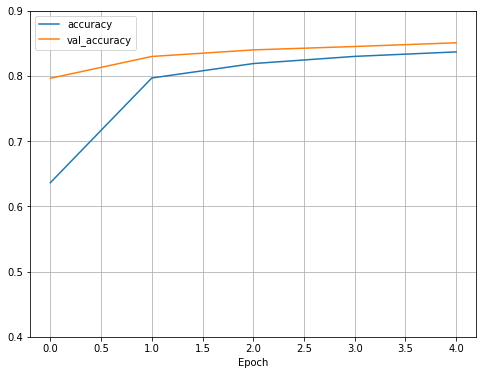

In [41]:
accuracies_5 = pd.DataFrame(history_5.history)[['accuracy','val_accuracy']]

accuracies_5.plot(figsize=(8,6))
plt.grid(True)
plt.gca().set_ylim(0.4,0.9)
plt.xlabel('Epoch')
plt.show()

In [42]:
print("VGG with three layers 64,128,256")
print(accuracies_5)

VGG with three layers 64,128,256
   accuracy  val_accuracy
0  0.636285      0.796301
1  0.796760      0.829756
2  0.818861      0.839814
3  0.829865      0.845030
4  0.836746      0.850718


### Compare:  2 or 3 layers

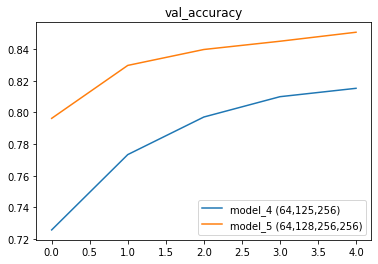

In [38]:
plt.plot(history_4.history['val_accuracy'],label = "model_4 (64,125,256)")
plt.plot(history_5.history['val_accuracy'],label = "model_5 (64,128,256,256)")
plt.title("val_accuracy")
plt.legend()
plt.show()

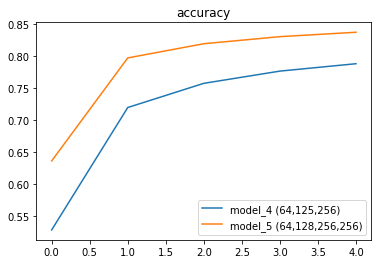

In [39]:
plt.plot(history_4.history['accuracy'],label = "model_4 (64,125,256)")
plt.plot(history_5.history['accuracy'],label = "model_5 (64,128,256,256)")
plt.title("accuracy")
plt.legend()
plt.show()

#### Four-layer model is better than three-layer model.

### VGG - four layers - neurons: 64,128,256,512 (BEST)

In [16]:
model_6 = Sequential()

# layer_1
model_6.add(Conv2D(64, (3, 3), strides=(1, 1), input_shape=(28, 28, 1), padding='same'))
model_6.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_2
model_6.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_6.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_3
model_6.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_6.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_4
model_6.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_6.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

#full connected layer
model_6.add(Flatten())
model_6.add(Dense(256, activation='relu'))
model_6.add(Dropout(0.5))
model_6.add(Dense(62, activation='softmax'))

model_6.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 512)        

In [18]:
model_6.compile(loss='sparse_categorical_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [45]:
batch_size = 128
epochs = 5
history_6 = model_6.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/5
4908/4908 [==============================] - 1385s 282ms/step - loss: 1.3429 - accuracy: 0.6361 - val_loss: 0.5673 - val_accuracy: 0.8107
Epoch 2/5
4908/4908 [==============================] - 1304s 266ms/step - loss: 0.6065 - accuracy: 0.8021 - val_loss: 0.4815 - val_accuracy: 0.8323
Epoch 3/5
4908/4908 [==============================] - 1305s 266ms/step - loss: 0.5237 - accuracy: 0.8233 - val_loss: 0.4427 - val_accuracy: 0.8421
Epoch 4/5
4908/4908 [==============================] - 1306s 266ms/step - loss: 0.4849 - accuracy: 0.8337 - val_loss: 0.4268 - val_accuracy: 0.8464
Epoch 5/5
4908/4908 [==============================] - 1315s 268ms/step - loss: 0.4603 - accuracy: 0.8406 - val_loss: 0.4096 - val_accuracy: 0.8524


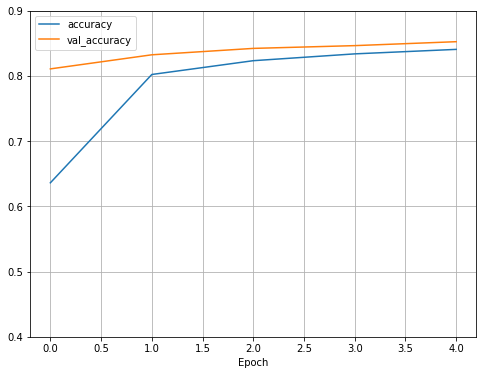

In [47]:
accuracies_6 = pd.DataFrame(history_6.history)[['accuracy','val_accuracy']]

accuracies_6.plot(figsize=(8,6))
plt.grid(True)
plt.gca().set_ylim(0.4,0.9)
plt.xlabel('Epoch')
plt.show()

In [48]:
print("VGG with three layers 64,128,256，256")
print(accuracies_6)

VGG with three layers 64,128,256
   accuracy  val_accuracy
0  0.636064      0.810714
1  0.802133      0.832307
2  0.823268      0.842121
3  0.833726      0.846362
4  0.840615      0.852394


### Compare: neurons on the forth layer

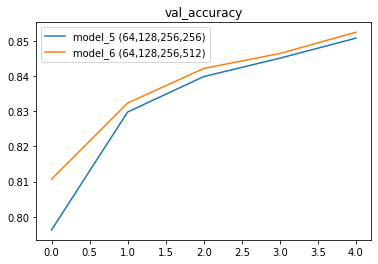

In [49]:
plt.plot(history_5.history['val_accuracy'],label = "model_5 (64,128,256,256)")
plt.plot(model_6.history['val_accuracy'],label = "model_6 (64,128,256,512)")
plt.title("val_accuracy")
plt.legend()
plt.show()

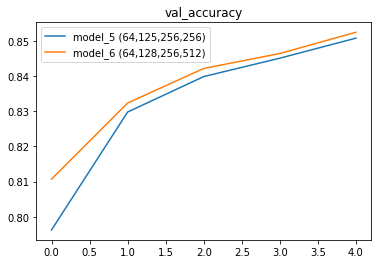

In [50]:
plt.plot(history_5.history['val_accuracy'],label = "model_5 (64,125,256,256)")
plt.plot(model_6.history['val_accuracy'],label = "model_6 (64,128,256,512)")
plt.title("val_accuracy")
plt.legend()
plt.show()

#### 512 on the forth layer is better than 256 on the forth layer.

### VGG - four layers - neurons: 64,128,256,512,512

In [9]:
model_7 = Sequential()

# layer_1
model_7.add(Conv2D(64, (3, 3), strides=(1, 1), input_shape=(28, 28, 1), padding='same'))
model_7.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# layer_2
model_7.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_7.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# layer_3
model_7.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_7.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# layer_4
model_7.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_7.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# layer_5
model_7.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_7.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

#full connected layer
model_7.add(Flatten())
model_7.add(Dense(256, activation='relu'))
model_7.add(Dropout(0.5))
model_7.add(Dense(62, activation='softmax'))

model_7.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 512)         1

In [10]:
model_7.compile(loss='sparse_categorical_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [11]:
batch_size = 128
epochs = 5
history_7 = model_7.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/5
4908/4908 [==============================] - 2135s 435ms/step - loss: 1.4139 - accuracy: 0.6189 - val_loss: 0.5651 - val_accuracy: 0.8092
Epoch 2/5
4908/4908 [==============================] - 2676s 545ms/step - loss: 0.5849 - accuracy: 0.8071 - val_loss: 0.4560 - val_accuracy: 0.8395
Epoch 3/5
4908/4908 [==============================] - 2712s 553ms/step - loss: 0.5003 - accuracy: 0.8295 - val_loss: 0.4538 - val_accuracy: 0.8405
Epoch 4/5
4908/4908 [==============================] - 2291s 467ms/step - loss: 0.4616 - accuracy: 0.8401 - val_loss: 0.4083 - val_accuracy: 0.8542
Epoch 5/5
4908/4908 [==============================] - 2124s 433ms/step - loss: 0.4375 - accuracy: 0.8466 - val_loss: 0.3961 - val_accuracy: 0.8556


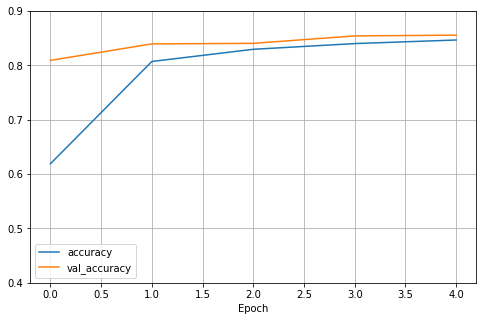

In [14]:
accuracies_7 = pd.DataFrame(history_7.history)[['accuracy','val_accuracy']]

accuracies_7.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.4,0.9)
plt.xlabel('Epoch')
plt.show()

In [15]:
print("VGG with three layers 64,128,256,512,521")
print(accuracies_7)

VGG with three layers 64,128,256,512,521
   accuracy  val_accuracy
0  0.618917      0.809167
1  0.807133      0.839456
2  0.829537      0.840488
3  0.840067      0.854171
4  0.846648      0.855575


#### Although the accuracy of the 5-layer model is 0.0032 higher than that of the 4-layer model, it takes twice as long. Therefore, the number of layers of the final selected model is 4.

### Choose the best optimizer: 'RMSprop', 'Adam', 'SGD'

#### Adam

In [9]:
model_9 = Sequential()

# layer_1
model_9.add(Conv2D(64, (3, 3), strides=(1, 1), input_shape=(28, 28, 1), padding='same'))
model_9.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_2
model_9.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_9.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_3
model_9.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_9.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_4
model_9.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_9.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

#full connected layer
model_9.add(Flatten())
model_9.add(Dense(256, activation='relu'))
model_9.add(Dropout(0.5))
model_9.add(Dense(62, activation='softmax'))

model_9.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 512)         1

In [10]:
model_9.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [14]:
batch_size = 128
epochs = 3
history_9 = model_9.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/3
4908/4908 [==============================] - 1338s 272ms/step - loss: 0.5415 - accuracy: 0.8225 - val_loss: 0.3748 - val_accuracy: 0.8624
Epoch 2/3
4908/4908 [==============================] - 1304s 266ms/step - loss: 0.3963 - accuracy: 0.8588 - val_loss: 0.3757 - val_accuracy: 0.8615
Epoch 3/3
4908/4908 [==============================] - 1312s 267ms/step - loss: 0.3712 - accuracy: 0.8651 - val_loss: 0.3598 - val_accuracy: 0.8677


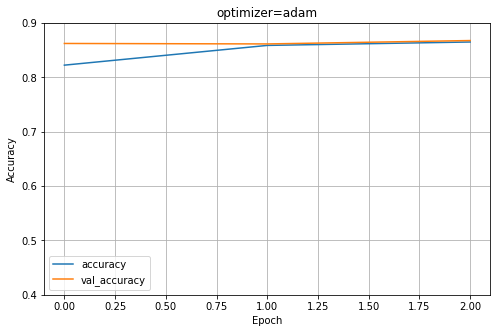

In [15]:
accuracies_9 = pd.DataFrame(history_9.history)[['accuracy','val_accuracy']]

accuracies_9.plot(figsize=(8,5))
plt.title("optimizer=adam")
plt.grid(True)
plt.gca().set_ylim(0.4,0.9)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#### SGD

In [19]:
batch_size = 128
epochs = 3
history_6 = model_6.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/3
4908/4908 [==============================] - 1363s 277ms/step - loss: 1.3052 - accuracy: 0.6439 - val_loss: 0.5541 - val_accuracy: 0.8144
Epoch 2/3
4908/4908 [==============================] - 1362s 277ms/step - loss: 0.6063 - accuracy: 0.8018 - val_loss: 0.4815 - val_accuracy: 0.8327
Epoch 3/3
4908/4908 [==============================] - 1277s 260ms/step - loss: 0.5251 - accuracy: 0.8231 - val_loss: 0.4383 - val_accuracy: 0.8442


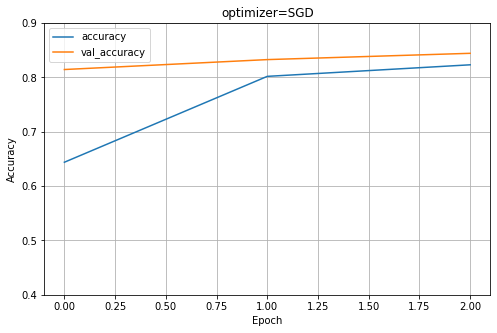

In [22]:
accuracies_6 = pd.DataFrame(history_6.history)[['accuracy','val_accuracy']]

accuracies_6.plot(figsize=(8,5))
plt.title("optimizer=SGD")
plt.grid(True)
plt.gca().set_ylim(0.4,0.9)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#### RMSprop

In [23]:
model_10 = Sequential()

# layer_1
model_10.add(Conv2D(64, (3, 3), strides=(1, 1), input_shape=(28, 28, 1), padding='same'))
model_10.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_2
model_10.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_10.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_3
model_10.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_10.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_4
model_10.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_10.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

#full connected layer
model_10.add(Flatten())
model_10.add(Dense(256, activation='relu'))
model_10.add(Dropout(0.5))
model_10.add(Dense(62, activation='softmax'))

model_10.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 512)        

In [24]:
model_10.compile(loss='sparse_categorical_crossentropy',
              optimizer="RMSprop",
              metrics=['accuracy'])

In [25]:
batch_size = 128
epochs = 3
history_10 = model_10.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/3
4908/4908 [==============================] - 1269s 258ms/step - loss: 0.5376 - accuracy: 0.8254 - val_loss: 0.4238 - val_accuracy: 0.8501
Epoch 2/3
4908/4908 [==============================] - 1277s 260ms/step - loss: 0.4541 - accuracy: 0.8481 - val_loss: 0.4498 - val_accuracy: 0.8505
Epoch 3/3
4908/4908 [==============================] - 1282s 261ms/step - loss: 0.4863 - accuracy: 0.8424 - val_loss: 0.4855 - val_accuracy: 0.8379


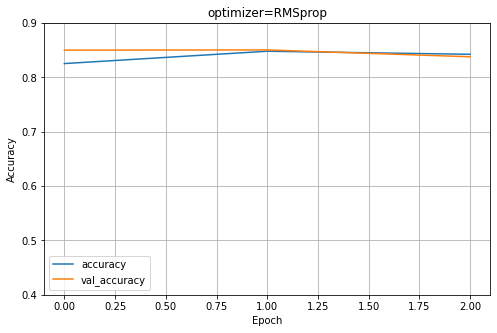

In [26]:
accuracies_10 = pd.DataFrame(history_10.history)[['accuracy','val_accuracy']]

accuracies_10.plot(figsize=(8,5))
plt.title("optimizer=RMSprop")
plt.grid(True)
plt.gca().set_ylim(0.4,0.9)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### Compare three optimizer

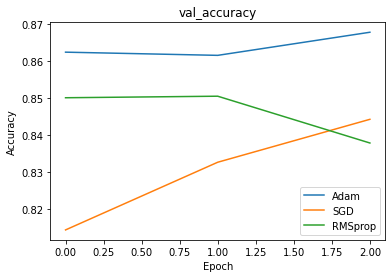

In [27]:
plt.plot(history_9.history['val_accuracy'],label = "Adam")
plt.plot(history_6.history['val_accuracy'],label = "SGD")
plt.plot(history_10.history['val_accuracy'],label = "RMSprop")
plt.title("val_accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


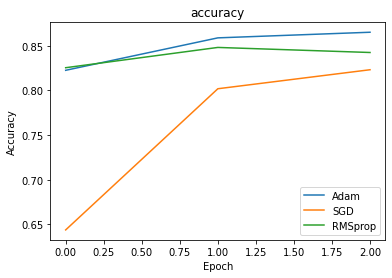

In [28]:
plt.plot(history_9.history['accuracy'],label = "Adam")
plt.plot(history_6.history['accuracy'],label = "SGD")
plt.plot(history_10.history['accuracy'],label = "RMSprop")
plt.title("accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#### Adam has the highest accuracy among the three optimizers.

### Choose the best learning rate: 0.01, 0.001, 0.0001

#### Learning rate = 0.01

In [13]:
model_1 = Sequential()

# layer_1
model_1.add(Conv2D(64, (3, 3), strides=(1, 1), input_shape=(28, 28, 1), padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_2
model_1.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_3
model_1.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_4
model_1.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

#full connected layer
model_1.add(Flatten())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(62, activation='softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 512)         1

In [16]:
opt_1 = tf.keras.optimizers.Adam(learning_rate=0.01)

In [17]:
model_1.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt_1,
              metrics=['accuracy'])

In [18]:
batch_size = 128
epochs = 3
history_1 = model_1.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/3
4908/4908 [==============================] - 1470s 299ms/step - loss: 1.3957 - accuracy: 0.5976 - val_loss: 0.8469 - val_accuracy: 0.7274
Epoch 2/3
4908/4908 [==============================] - 1449s 295ms/step - loss: 1.0695 - accuracy: 0.6771 - val_loss: 0.8960 - val_accuracy: 0.7214
Epoch 3/3
4908/4908 [==============================] - 1436s 293ms/step - loss: 1.0524 - accuracy: 0.6835 - val_loss: 0.8068 - val_accuracy: 0.7439


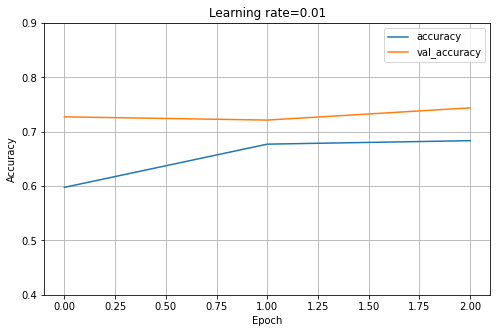

In [20]:
accuracies_1 = pd.DataFrame(history_1.history)[['accuracy','val_accuracy']]

accuracies_1.plot(figsize=(8,5))
plt.title("Learning rate=0.01")
plt.grid(True)
plt.gca().set_ylim(0.4,0.9)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#### Learning rate = 0.0001

In [21]:
model_2 = Sequential()

# layer_1
model_2.add(Conv2D(64, (3, 3), strides=(1, 1), input_shape=(28, 28, 1), padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_2
model_2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_3
model_2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_4
model_2.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

#full connected layer
model_2.add(Flatten())
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(62, activation='softmax'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 512)        

In [22]:
opt_2 = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [23]:
model_2.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt_2,
              metrics=['accuracy'])

In [24]:
batch_size = 128
epochs = 3
history_2 = model_2.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/3
4908/4908 [==============================] - 1495s 304ms/step - loss: 0.8227 - accuracy: 0.7563 - val_loss: 0.4360 - val_accuracy: 0.8451
Epoch 2/3
4908/4908 [==============================] - 1507s 307ms/step - loss: 0.4728 - accuracy: 0.8379 - val_loss: 0.3908 - val_accuracy: 0.8587
Epoch 3/3
4908/4908 [==============================] - 1526s 311ms/step - loss: 0.4171 - accuracy: 0.8528 - val_loss: 0.3675 - val_accuracy: 0.8634


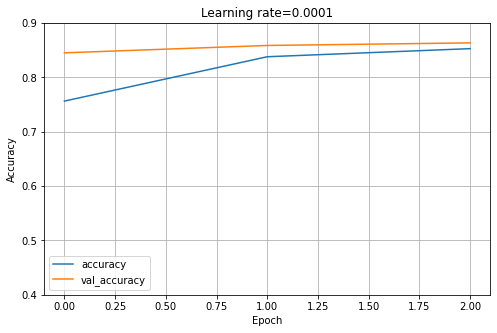

In [25]:
accuracies_2 = pd.DataFrame(history_2.history)[['accuracy','val_accuracy']]

accuracies_2.plot(figsize=(8,5))
plt.title("Learning rate=0.0001")
plt.grid(True)
plt.gca().set_ylim(0.4,0.9)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [31]:
batch_size = 128
epochs = 3
history_9 = model_9.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/3
4908/4908 [==============================] - 1472s 299ms/step - loss: 0.5415 - accuracy: 0.8220 - val_loss: 0.3865 - val_accuracy: 0.8577
Epoch 2/3
4908/4908 [==============================] - 1488s 303ms/step - loss: 0.3971 - accuracy: 0.8591 - val_loss: 0.3634 - val_accuracy: 0.8656
Epoch 3/3
4908/4908 [==============================] - 1493s 304ms/step - loss: 0.3725 - accuracy: 0.8649 - val_loss: 0.3591 - val_accuracy: 0.8685


### Compare: three learning rates

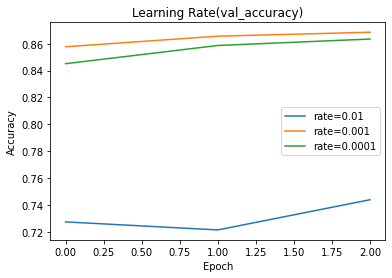

In [32]:
plt.plot(history_1.history['val_accuracy'],label = "rate=0.01")
plt.plot(history_9.history['val_accuracy'],label = "rate=0.001")
plt.plot(history_2.history['val_accuracy'],label = "rate=0.0001")
plt.title("Learning Rate(val_accuracy)")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

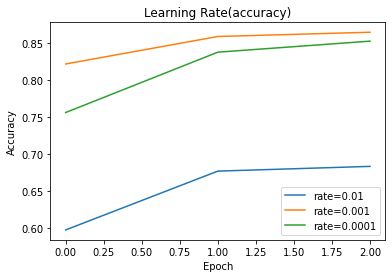

In [33]:
plt.plot(history_1.history['accuracy'],label = "rate=0.01")
plt.plot(history_9.history['accuracy'],label = "rate=0.001")
plt.plot(history_2.history['accuracy'],label = "rate=0.0001")
plt.title("Learning Rate(accuracy)")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Of the three different learning rates, the model with a learning rate of 0.001 had the highest accuracy.

### Choose the best dropout: 0.5 or 0.25

#### dropout = 0.25

In [13]:
model_3 = Sequential()

# layer_1
model_3.add(Conv2D(64, (3, 3), strides=(1, 1), input_shape=(28, 28, 1), padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_2
model_3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_3
model_3.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_4
model_3.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

#full connected layer
model_3.add(Flatten())
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.25))
model_3.add(Dense(62, activation='softmax'))

model_3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 512)        

In [14]:
model_3.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [15]:
batch_size = 128
epochs = 3
history_3 = model_3.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/3
4908/4908 [==============================] - 1370s 279ms/step - loss: 0.4975 - accuracy: 0.8318 - val_loss: 0.3830 - val_accuracy: 0.8581
Epoch 2/3
4908/4908 [==============================] - 1321s 269ms/step - loss: 0.3769 - accuracy: 0.8620 - val_loss: 0.3586 - val_accuracy: 0.8659
Epoch 3/3
4908/4908 [==============================] - 1304s 266ms/step - loss: 0.3553 - accuracy: 0.8682 - val_loss: 0.3575 - val_accuracy: 0.8647


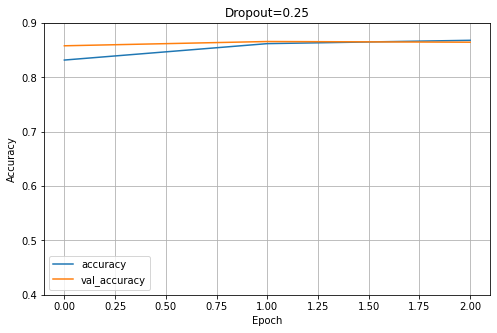

In [16]:
accuracies_3 = pd.DataFrame(history_3.history)[['accuracy','val_accuracy']]

accuracies_3.plot(figsize=(8,5))
plt.title("Dropout=0.25")
plt.grid(True)
plt.gca().set_ylim(0.4,0.9)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#### Dropout = 0.5

In [19]:
batch_size = 128
epochs = 3
history_9 = model_9.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/3
4908/4908 [==============================] - 1384s 282ms/step - loss: 0.5357 - accuracy: 0.8237 - val_loss: 0.3940 - val_accuracy: 0.8549
Epoch 2/3
4908/4908 [==============================] - 1414s 288ms/step - loss: 0.3974 - accuracy: 0.8586 - val_loss: 0.3684 - val_accuracy: 0.8638
Epoch 3/3
4908/4908 [==============================] - 1299s 265ms/step - loss: 0.3715 - accuracy: 0.8651 - val_loss: 0.3562 - val_accuracy: 0.8682


### Compare: dropout 0.5 or 0.25

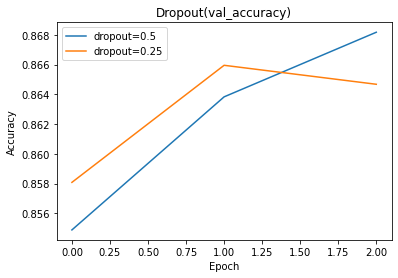

In [20]:
plt.plot(history_9.history['val_accuracy'],label = "dropout=0.5")
plt.plot(history_3.history['val_accuracy'],label = "dropout=0.25")
plt.title("Dropout(val_accuracy)")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

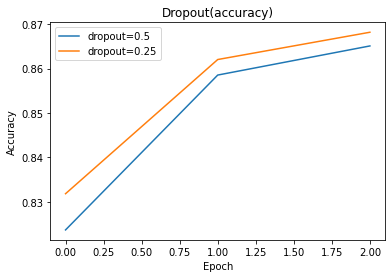

In [21]:
plt.plot(history_9.history['accuracy'],label = "dropout=0.5")
plt.plot(history_3.history['accuracy'],label = "dropout=0.25")
plt.title("Dropout(accuracy)")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### According to the accuracy of the validation set, it can be concluded that the accuracy of dropout 0.5 is higher than that of dropout 0.25.

### Choose the best fully connected layers

#### two fully connected layers

In [22]:
model_8 = Sequential()

# layer_1
model_8.add(Conv2D(64, (3, 3), strides=(1, 1), input_shape=(28, 28, 1), padding='same'))
model_8.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_2
model_8.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_8.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_3
model_8.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_8.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_4
model_8.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_8.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

#full connected layer
model_8.add(Flatten())
model_8.add(Dense(512, activation='relu'))
model_8.add(Dense(256, activation='relu'))
model_8.add(Dropout(0.5))
model_8.add(Dense(62, activation='softmax'))

model_8.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 512)        

In [23]:
model_8.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [24]:
batch_size = 128
epochs = 3
history_8 = model_8.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/3
4908/4908 [==============================] - 1334s 272ms/step - loss: 0.5218 - accuracy: 0.8272 - val_loss: 0.3993 - val_accuracy: 0.8532
Epoch 2/3
4908/4908 [==============================] - 1331s 271ms/step - loss: 0.3880 - accuracy: 0.8608 - val_loss: 0.3798 - val_accuracy: 0.8615
Epoch 3/3
4908/4908 [==============================] - 1350s 275ms/step - loss: 0.3645 - accuracy: 0.8666 - val_loss: 0.3649 - val_accuracy: 0.8673


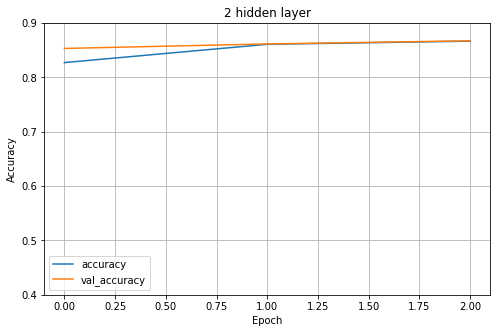

In [27]:
accuracies_8 = pd.DataFrame(history_8.history)[['accuracy','val_accuracy']]

accuracies_8.plot(figsize=(8,5))
plt.title("2 fully connected layers")
plt.grid(True)
plt.gca().set_ylim(0.4,0.9)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### Compare: fully connected layers

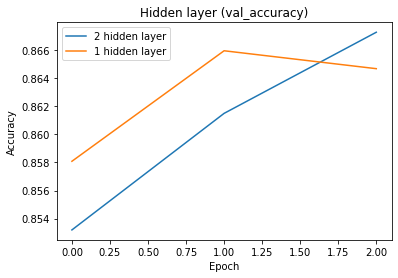

In [30]:
plt.plot(history_8.history['val_accuracy'],label = "2 hidden layer")
plt.plot(history_3.history['val_accuracy'],label = "1 hidden layer")
plt.title("Fully connected layer (val_accuracy)")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

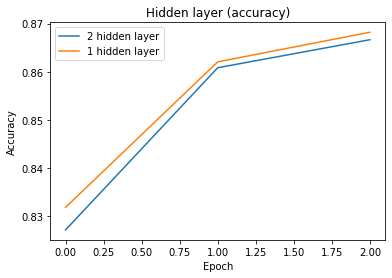

In [31]:
plt.plot(history_8.history['accuracy'],label = "2 hidden layer")
plt.plot(history_3.history['accuracy'],label = "1 hidden layer")
plt.title("Fully connected layer (accuracy)")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### According to the accuracy of the validation set, it can be concluded that the accuracy of 2  fully connected layers is higher than that of 1 layers.

#### Three fully connected layers

In [46]:
model_4 = Sequential()

# layer_1
model_4.add(Conv2D(64, (3, 3), strides=(1, 1), input_shape=(28, 28, 1), padding='same'))
model_4.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_2
model_4.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_4.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_3
model_4.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_4.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_4
model_4.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_4.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

#full connected layer
model_4.add(Flatten())
model_4.add(Dense(512, activation='relu'))
model_4.add(Dense(256, activation='relu'))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(62, activation='softmax'))

model_4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 512)        

In [47]:
model_4.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [48]:
batch_size = 128
epochs = 3
history_4 = model_4.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/3
4908/4908 [==============================] - 1278s 260ms/step - loss: 0.5711 - accuracy: 0.8187 - val_loss: 0.3937 - val_accuracy: 0.8582
Epoch 2/3
4908/4908 [==============================] - 1409s 287ms/step - loss: 0.4089 - accuracy: 0.8579 - val_loss: 0.3891 - val_accuracy: 0.8599
Epoch 3/3
4908/4908 [==============================] - 1324s 270ms/step - loss: 0.3841 - accuracy: 0.8642 - val_loss: 0.3764 - val_accuracy: 0.8647


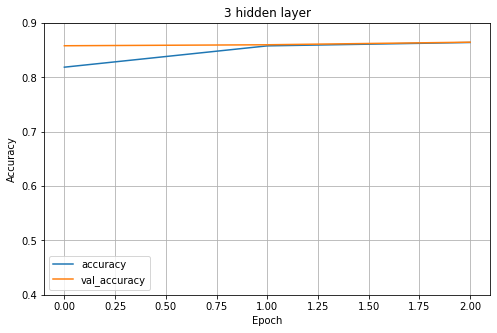

In [49]:
accuracies_4 = pd.DataFrame(history_4.history)[['accuracy','val_accuracy']]

accuracies_4.plot(figsize=(8,5))
plt.title("3 fully connected layer")
plt.grid(True)
plt.gca().set_ylim(0.4,0.9)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### Compare: number of fully connected layers

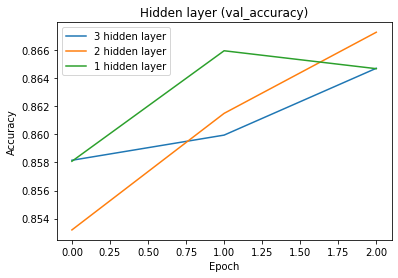

In [50]:
plt.plot(history_4.history['val_accuracy'],label = "3 hidden layer")
plt.plot(history_8.history['val_accuracy'],label = "2 hidden layer")
plt.plot(history_3.history['val_accuracy'],label = "1 hidden layer")
plt.title("Fully connected layer (val_accuracy)")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

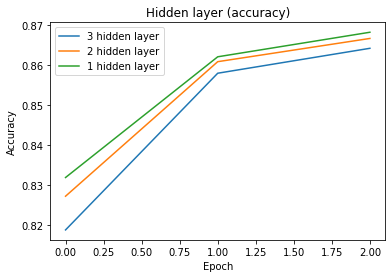

In [51]:
plt.plot(history_4.history['accuracy'],label = "3 hidden layer")
plt.plot(history_8.history['accuracy'],label = "2 hidden layer")
plt.plot(history_3.history['accuracy'],label = "1 hidden layer")
plt.title("Fully connected layer (accuracy)")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### According to the accuracy of the validation set, it can be concluded that the accuracy of 2 fully connected layers has the highest accuracy.¶

### Final Model with epoch = 10

In [10]:
time_start =time.time()

model_final = Sequential()

# layer_1
model_final.add(Conv2D(64, (3, 3), strides=(1, 1), input_shape=(28, 28, 1), padding='same'))
model_final.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_2
model_final.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_final.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_3
model_final.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_final.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

# layer_4
model_final.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_final.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

#full connected layer
model_final.add(Flatten())
model_final.add(Dense(512, activation='relu'))
model_final.add(Dense(256, activation='relu'))
model_final.add(Dropout(0.5))
model_final.add(Dense(62, activation='softmax'))

model_final.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 512)         1

In [11]:
model_final.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [14]:
early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0,
    mode='auto'
)


In [18]:
batch_size = 128
epochs = 10
history_final = model_final.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid),
                                callbacks = [early_stop_cb])

Epoch 1/10
4908/4908 [==============================] - 1414s 288ms/step - loss: 0.4657 - accuracy: 0.8399 - val_loss: 0.3876 - val_accuracy: 0.8579
Epoch 2/10
4908/4908 [==============================] - 1451s 296ms/step - loss: 0.3880 - accuracy: 0.8612 - val_loss: 0.3699 - val_accuracy: 0.8637
Epoch 3/10
4908/4908 [==============================] - 1362s 277ms/step - loss: 0.3653 - accuracy: 0.8673 - val_loss: 0.3750 - val_accuracy: 0.8649
Epoch 4/10
4908/4908 [==============================] - 1357s 277ms/step - loss: 0.3514 - accuracy: 0.8708 - val_loss: 0.3681 - val_accuracy: 0.8649
Epoch 5/10
4908/4908 [==============================] - 1402s 286ms/step - loss: 0.3410 - accuracy: 0.8728 - val_loss: 0.3719 - val_accuracy: 0.8649
Epoch 6/10
4908/4908 [==============================] - 1329s 271ms/step - loss: 0.3336 - accuracy: 0.8752 - val_loss: 0.3691 - val_accuracy: 0.8655
Epoch 7/10
4908/4908 [==============================] - 1347s 274ms/step - loss: 0.3285 - accuracy: 0.8766

In [19]:
time_end=time.time()
time_c =time_end - time_start
print('time cost',time_c,'s')

time cost 11496.632786750793 s


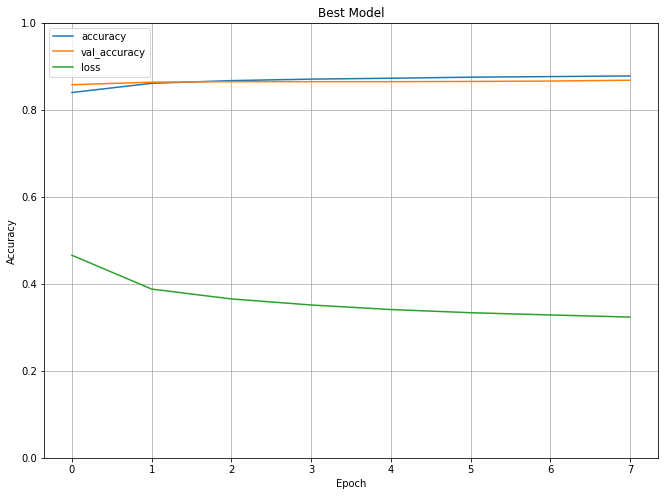

In [20]:
accuracies_final = pd.DataFrame(history_final.history)[['accuracy','val_accuracy','loss']]
accuracies_final.plot(figsize=(11,8))
plt.title("Best Model")
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### Using the final model do predict on test set

In [21]:
X_test = np.expand_dims(X_test, -1)

In [22]:
loss,accuracy = model_final.evaluate(X_test,test_lab_raw)
print(f'Accuracy on test data: {accuracy:.4f}')

3636/3636 [==============================] - 95s 26ms/step - loss: 0.3721 - accuracy: 0.8709
Accuracy on test data: 0.8709


### Show accuracy, precision, recall, F1 score of the prediction

In [26]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


test_sample = X_test
pred = model_final.predict(test_sample).round(2)
y_predict = np.argmax(pred, axis = -1)

print('The accuracy socre of VGG model is: {:.2f} '.format(accuracy_score(test_lab_raw,y_predict)))
print('The precision socre of VGG model is: {:.2f} '.format(precision_score(test_lab_raw,y_predict,average='weighted')))
print('The recall socre of VGG model is: {:.2f} '.format(recall_score(test_lab_raw,y_predict,average='weighted')))
print('The F1 socre of VGG model is: {:.2f} '.format(f1_score(test_lab_raw,y_predict,average='weighted')))



The accuracy socre of VGG model is: 0.87 
The precision socre of VGG model is: 0.86 
The recall socre of VGG model is: 0.87 
The F1 socre of VGG model is: 0.85 
